In [1]:
import numpy as np
import json
import pandas as pd
import pathlib
import os
from tqdm.auto import tqdm
import tensorflow as tf
import PIL
import PIL.Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model, Input

2025-01-21 13:42:03.156153: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-21 13:42:03.167420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737447123.180102  260645 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737447123.183745  260645 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 13:42:03.198698: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [3]:
parent_directory = "parasite-dataset"

# Initialize empty lists to store image paths and class names
image_paths = []
class_names = []

# Iterate through subfolders (classes)
for class_name in tqdm(os.listdir(parent_directory)):
    class_path = os.path.join(parent_directory, class_name)
    
    # Check if the item is a directory (to exclude files)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            # Assuming the image files have a common extension like '.jpg', adjust accordingly
            if image_name.endswith('.jpg'):
                image_path = os.path.join(class_path, image_name)
                
                # Append the image path and class name to the lists
                image_paths.append(image_path)
                class_names.append(class_name)

# Create a DataFrame
df = pd.DataFrame({'Image_Path': image_paths, 'Class_Name': class_names})

# Display the DataFrame
print(df.head())

  0%|          | 0/9 [00:00<?, ?it/s]

                                   Image_Path Class_Name
0  parasite-dataset/Babesia/0109_141708_1.jpg    Babesia
1  parasite-dataset/Babesia/0109_141738_1.jpg    Babesia
2  parasite-dataset/Babesia/0109_141738_2.jpg    Babesia
3  parasite-dataset/Babesia/0109_141738_3.jpg    Babesia
4  parasite-dataset/Babesia/0109_141738_4.jpg    Babesia


In [4]:
df['Class_Name'].value_counts()

Class_Name
Trichomonad    10134
RBCs            8995
Toxoplasma      2933
Leishmania      2701
Trypanosome     2385
Babesia         1173
Leukocyte       1084
Plasmodium       843
Name: count, dtype: int64

In [5]:
batch_size = 64
IMG_SIZE = (224,224)
epochs = 50
early_stop_patience = 10

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Adjust preprocessing as needed


train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Class_Name'])
test_df, valid_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['Class_Name'])


train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image_Path',
    y_col='Class_Name',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


validation_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image_Path',
    y_col='Class_Name',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image_Path',
    y_col='Class_Name',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


images, labels = next(train_generator)
print(images.shape)
print(labels.shape)

Found 19359 validated image filenames belonging to 8 classes.
Found 4839 validated image filenames belonging to 8 classes.
Found 3025 validated image filenames belonging to 8 classes.
(64, 224, 224, 3)
(64, 8)


In [9]:
# base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
# for layer in base_model.layers[8:]:
#     layer.trainable = False

# # Add custom layers on top
# inputs = Input(shape=(224, 224, 3))
# x = base_model(inputs, training=False)
# x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(32, activation='relu')(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

# model = Model(inputs, outputs)
# model.summary()

I0000 00:00:1737439814.598746  126956 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6195 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.summary()

I0000 00:00:1737442433.266595  175489 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6195 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 512)  │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 1024)   │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,085,160 (19.40 MB)

 Trainable params: 5,084,968 (19.40 MB)

 Non-trainable params: 192 (768.00 B)

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'f1_score'])

In [10]:
from sklearn.utils.class_weight import compute_class_weight

In [11]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

In [12]:
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience, restore_best_weights=True)
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath="parasite-detector.keras",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=[early_stopping, model_ckpt],
    validation_data=validation_generator, class_weight=class_weight_dict)

Epoch 1/50


/home/partha/miniconda3/envs/tflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1737442476.449116  177207 service.cc:148] XLA service 0x7f79e4007e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737442476.449144  177207 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-21 12:24:36.507863: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737442476.772458  177207 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-21 12:24:41.575857

215/303 ━━━━━━━━━━━━━━━━━━━━ 27s 317ms/step - accuracy: 0.3093 - f1_score: 0.2553 - loss: 2.0610

2025-01-21 12:26:59.780702: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[31,112,112,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[31,112,112,64]{3,2,1,0}, f16[512,3,3,64]{3,2,1,0}, f16[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-01-21 12:27:04.918961: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 6.13847793s
Trying algorithm eng0{} for conv (f16[31,112,112,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[31,112,112,64]{3,2,1,0}, f16[512,3,3,64]{3,2,1,0}, f16[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backen

303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.3451 - f1_score: 0.2856 - loss: 1.9273

2025-01-21 12:27:59.879345: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_147', 12 bytes spill stores, 12 bytes spill loads

2025-01-21 12:28:00.015986: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_147_0', 4 bytes spill stores, 4 bytes spill loads

2025-01-21 12:28:04.124648: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[64,112,112,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,112,112,64]{3,2,1,0}, f16[512,3,3,64]{3,2,1,0}, f16[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"opera

303/303 ━━━━━━━━━━━━━━━━━━━━ 246s 567ms/step - accuracy: 0.3455 - f1_score: 0.2859 - loss: 1.9259 - val_accuracy: 0.5005 - val_f1_score: 0.3962 - val_loss: 1.2184
Epoch 2/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 104s 342ms/step - accuracy: 0.6657 - f1_score: 0.5669 - loss: 1.0264 - val_accuracy: 0.4406 - val_f1_score: 0.3203 - val_loss: 1.6803
Epoch 3/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 104s 342ms/step - accuracy: 0.7274 - f1_score: 0.6513 - loss: 0.7804 - val_accuracy: 0.7828 - val_f1_score: 0.7049 - val_loss: 0.6090
Epoch 4/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 104s 342ms/step - accuracy: 0.8061 - f1_score: 0.7478 - loss: 0.5437 - val_accuracy: 0.9010 - val_f1_score: 0.8683 - val_loss: 0.3999
Epoch 5/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 104s 342ms/step - accuracy: 0.8290 - f1_score: 0.7688 - loss: 0.4766 - val_accuracy: 0.9525 - val_f1_score: 0.9245 - val_loss: 0.2044
Epoch 6/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 103s 340ms/step - accuracy: 0.8733 - f1_score: 0.8198 - loss: 0.3621 - val_accuracy: 0.8312 - val_f1_

In [7]:
model = tf.keras.models.load_model("parasite-detector.keras")

I0000 00:00:1737447132.997465  260645 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6195 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [9]:
pred = model.predict(test_generator, batch_size=batch_size)

/home/partha/miniconda3/envs/tflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-01-21 13:42:31.458295: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1737447151.467360  261100 service.cc:148] XLA service 0x7fe54c4039c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737447151.467389  261100 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-21 13:42:31.506528: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling M

 3/48 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step

I0000 00:00:1737447171.901235  261100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

2025-01-21 13:42:58.840430: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[17,112,112,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[17,112,112,64]{3,2,1,0}, f16[512,3,3,64]{3,2,1,0}, f16[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-01-21 13:43:01.232273: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.391917279s
Trying algorithm eng0{} for conv (f16[17,112,112,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[17,112,112,64]{3,2,1,0}, f16[512,3,3,64]{3,2,1,0}, f16[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBiasActivationForward", backe

48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step


In [10]:
cm = metrics.confusion_matrix(pred.argmax(1), test_generator.classes)

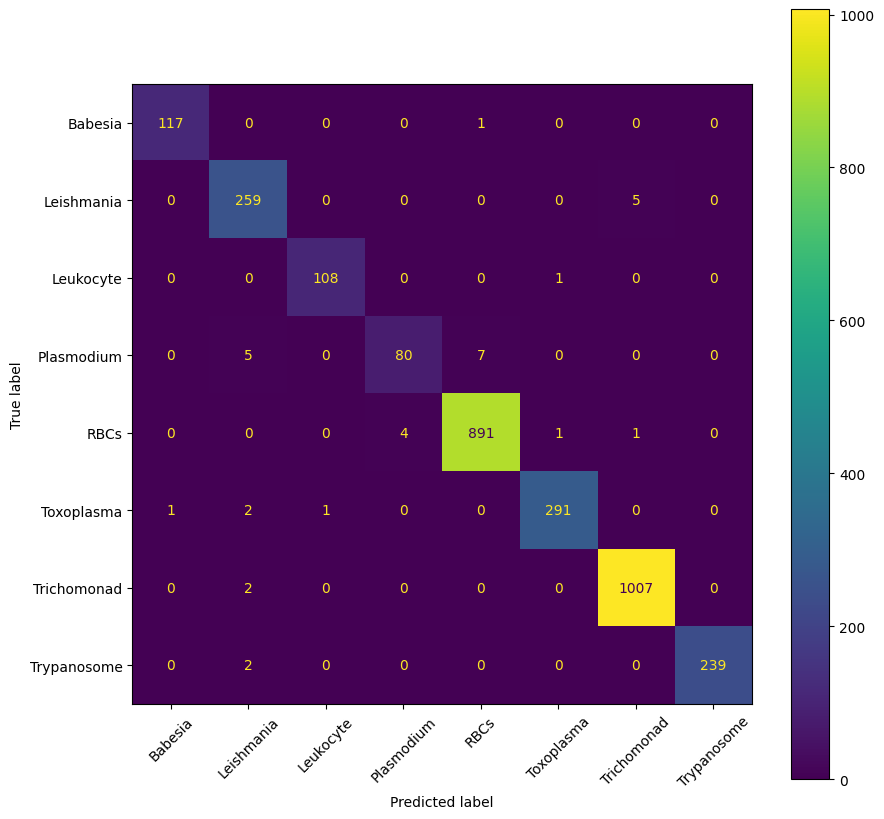

In [11]:
cmp = metrics.ConfusionMatrixDisplay(cm, display_labels=test_generator.class_indices)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax);
plt.xticks(rotation=45);

In [36]:
train_images, train_labels = next(test_generator)

In [37]:
predictions_batch = model.predict(train_images, verbose=0)

predicted_class_indices_batch = np.argmax(predictions_batch, axis=1)
class_labels = {v: k for k, v in test_generator.class_indices.items()}
predicted_class_labels_batch = [class_labels[idx] for idx in predicted_class_indices_batch]

num_images = len(train_images)
num_rows = int(np.ceil(num_images / 4))
num_cols = min(num_images, 4)

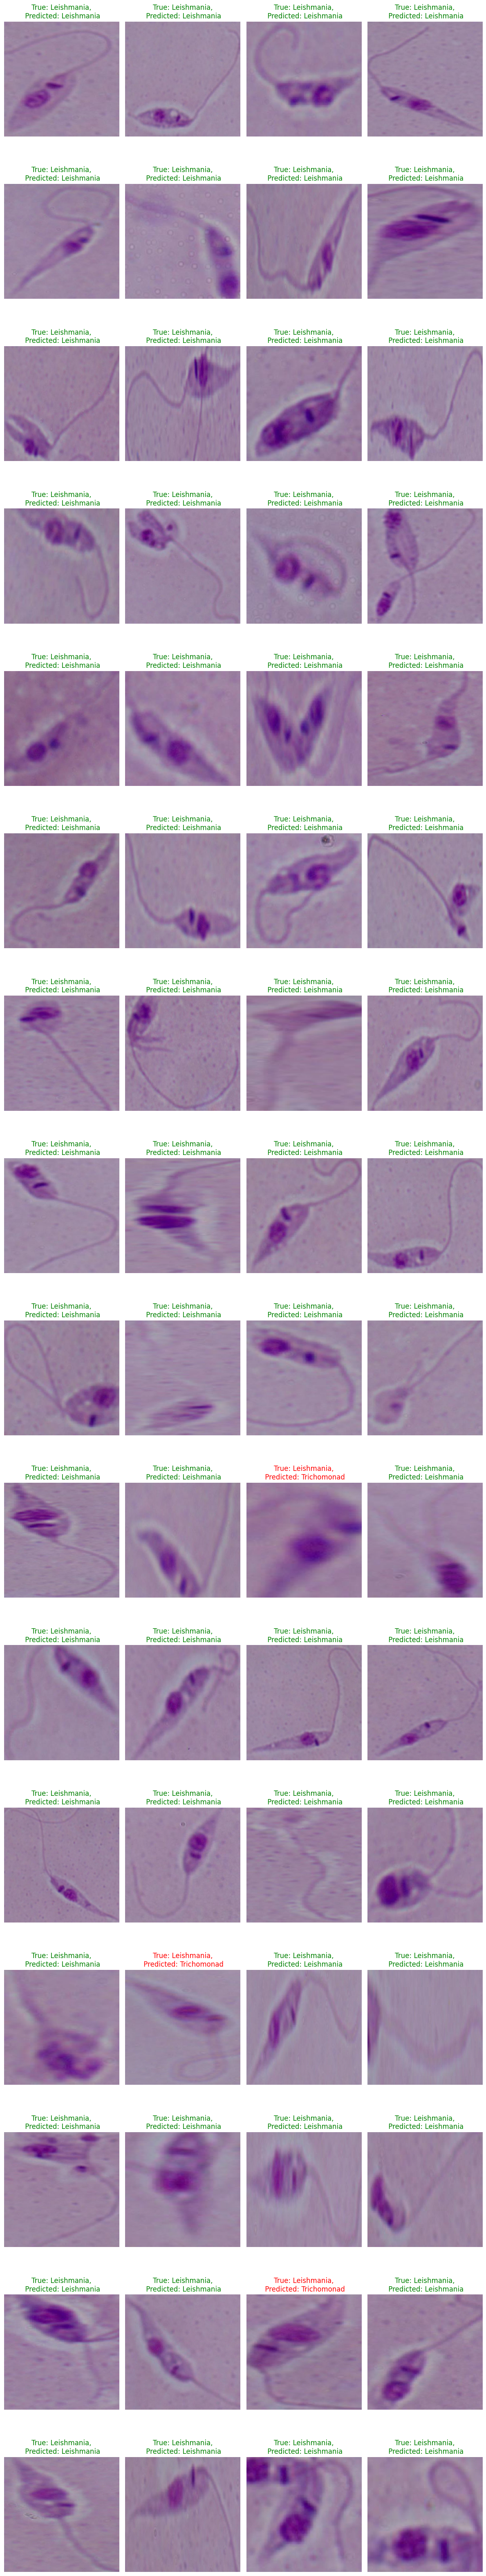

In [38]:
plt.figure(figsize=(12, 4 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(train_images[i])
    
    # Set title color based on the correctness of prediction
    title_color = 'green' if predicted_class_labels_batch[i] == class_labels[np.argmax(train_labels[i])] else 'red'
    
    plt.title(f'True: {class_labels[np.argmax(train_labels[i])]},\n Predicted: {predicted_class_labels_batch[i]}', color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
print(metrics.classification_report(test_generator.classes, pred.argmax(1), target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

     Babesia       0.99      0.99      0.99       118
  Leishmania       0.98      0.96      0.97       270
   Leukocyte       0.99      0.99      0.99       109
  Plasmodium       0.87      0.95      0.91        84
        RBCs       0.99      0.99      0.99       899
  Toxoplasma       0.99      0.99      0.99       293
 Trichomonad       1.00      0.99      1.00      1013
 Trypanosome       0.99      1.00      1.00       239

    accuracy                           0.99      3025
   macro avg       0.98      0.98      0.98      3025
weighted avg       0.99      0.99      0.99      3025



In [19]:
with open("class_label_mappings.json", "w") as f:
    json.dump(test_generator.class_indices, f, indent=4)